In [56]:
import pgmpy as pg
from pgmpy.readwrite import BIFReader
import networkx as nx
from pgmpy.models import BayesianModel, BayesianNetwork
from networkx.drawing.nx_pydot import graphviz_layout
import pydot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pgmpy.estimators import HillClimbSearch, K2Score, ExhaustiveSearch, BicScore, BDeuScore, BDsScore, MmhcEstimator, BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

import itertools

In [57]:
def draw_graph(model):
    p = graphviz_layout(model, prog="dot")
    plt.figure(figsize=(15, 8))
    nx.draw(model, with_labels=True, pos=p, node_size=1400, node_color="green", font_size=6)
    # plt.savefig('manualConstructedModel.png')
    plt.show()

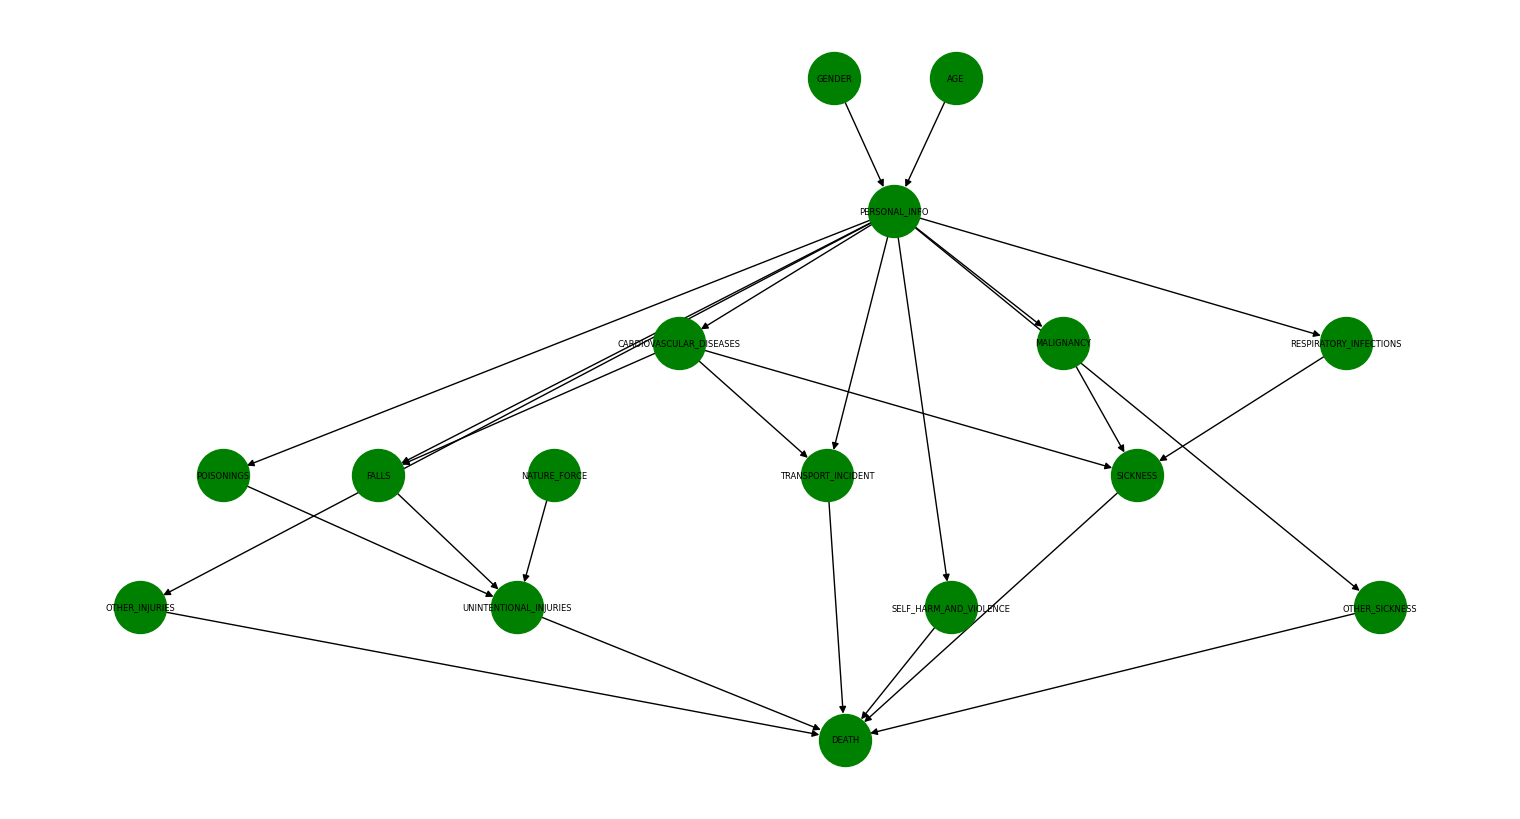

In [69]:
# Manual constructed model
manualConstructedModel = BayesianNetwork([
    ('GENDER', 'PERSONAL_INFO'), 
    ('AGE', 'PERSONAL_INFO'), 
    ('PERSONAL_INFO', 'OTHER_INJURIES'), 
    ('PERSONAL_INFO', 'FALLS'), 
    ('PERSONAL_INFO', 'POISONINGS'), 
    ('PERSONAL_INFO', 'TRANSPORT_INCIDENT'), 
    ('PERSONAL_INFO', 'SELF_HARM_AND_VIOLENCE'), 
    ('PERSONAL_INFO', 'RESPIRATORY_INFECTIONS'),
    ('PERSONAL_INFO', 'MALIGNANCY'), 
    ('PERSONAL_INFO', 'OTHER_SICKNESS'), 
    ('PERSONAL_INFO', 'CARDIOVASCULAR_DISEASES'),
    ('CARDIOVASCULAR_DISEASES', 'FALLS'), 
    ('CARDIOVASCULAR_DISEASES','TRANSPORT_INCIDENT'),
    ('CARDIOVASCULAR_DISEASES', 'SICKNESS'),
    ('OTHER_INJURIES', 'DEATH'),
    ('UNINTENTIONAL_INJURIES','DEATH'),
    ('FALLS', 'UNINTENTIONAL_INJURIES'), 
    ('POISONINGS', 'UNINTENTIONAL_INJURIES'), 
    ('NATURE_FORCE', 'UNINTENTIONAL_INJURIES'), 
    ('TRANSPORT_INCIDENT', 'DEATH'), 
    ('SELF_HARM_AND_VIOLENCE', 'DEATH'), 
    ('RESPIRATORY_INFECTIONS', 'SICKNESS'), 
    ('MALIGNANCY', 'SICKNESS'), 
    ('OTHER_SICKNESS', 'DEATH'),
    ('SICKNESS', 'DEATH')
])


draw_graph(manualConstructedModel)

In [59]:
# Data retrieving using Bif file and dataset construction

data = BIFReader("./data/probabilities.bif")

In [60]:
# Dataset retrieving

dataset = pd.read_csv("./data/dataset.csv")
dataset.info()
dataset.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ID                      100000 non-null  int64 
 1   Age-range               100000 non-null  object
 2   Gender                  100000 non-null  object
 3   Falls                   100000 non-null  int64 
 4   Poisonings              100000 non-null  int64 
 5   Nature-force            100000 non-null  int64 
 6   Cardiovascular-disease  100000 non-null  int64 
 7   Malignancy              100000 non-null  int64 
 8   Respiratory-infection   100000 non-null  int64 
 9   Transport-incident      100000 non-null  int64 
 10  Sickness                100000 non-null  int64 
 11  Other-injuries          100000 non-null  int64 
 12  Unintentional-injuries  100000 non-null  int64 
 13  Other-sickness          100000 non-null  int64 
 14  SHV                     100000 non-nu

,ID,Age-range,Gender,Falls,Poisonings,Nature-force,Cardiovascular-disease,Malignancy,Respiratory-infection,Transport-incident,Sickness,Other-injuries,Unintentional-injuries,Other-sickness,SHV,Death
0,1,young,female,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,young,female,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,young,female,0,0,0,1,0,1,0,0,0,0,0,0,0
3,4,young,female,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,young,female,0,0,0,0,0,1,0,0,0,0,0,0,0


In [61]:
# Creation of a compressed dataset grouping data for age-range

compressed_dataset = dataset.drop("ID",axis=1).groupby(["Age-range","Gender"]).sum()
compressed_dataset.head(6)

Falls  Poisonings  Nature-force  Cardiovascular-disease  \
Age-range Gender                                                            
adult     female   1838         243           419                     273   
          male     2546         294           445                    1459   
old       female    542          13            70                     144   
          male      672          13            61                      89   
young     female   2244         155           207                      57   
          male     2819         238           238                    1319   

                  Malignancy  Respiratory-infection  Transport-incident  \
Age-range Gender                                                          
adult     female        1996                   5459                1652   
          male          2481                   4339                3039   
old       female         641                   1004                 115   
          male           791                    845                 161   
young     female          38                   6616                 239   
          male            51                   5386                 336   

                  Sickness  Other-injuries  Unintentional-injuries  \
Age-range Gender                                                     
adult     female        71               2                       3   
          male         129              10                       3   
old       female        23               2                       3   
          male          23               3                       1   
young     female        38              19                       4   
          male         106               1                       5   

                  Other-sickness  SHV  Death  
Age-range Gender                              
adult     female              29  335    323  
          male                92  733    680  
old       female              52   31     48  
          male                82   68     63  
young     female              33    1     62  
          male                51    4     98

In [62]:
columns = ["Falls","Poisonings","Nature-force","Cardiovascular-disease","Malignancy","Respiratory-infection","Transport-incident","Sickness","Other-injuries","Unintentional-injuries","Other-sickness","SHV","Death"]
index = ["male","female"]

young = np.array(compressed_dataset.drop(["old","adult"]))
adult = np.array(compressed_dataset.drop(["young","old"]))
old = np.array(compressed_dataset.drop(["young","adult"]))

dataYoung = pd.DataFrame(young,index=index, columns=columns)
dataAdult = pd.DataFrame(adult,index=index, columns=columns)
dataOld = pd.DataFrame(old,index=index, columns=columns)



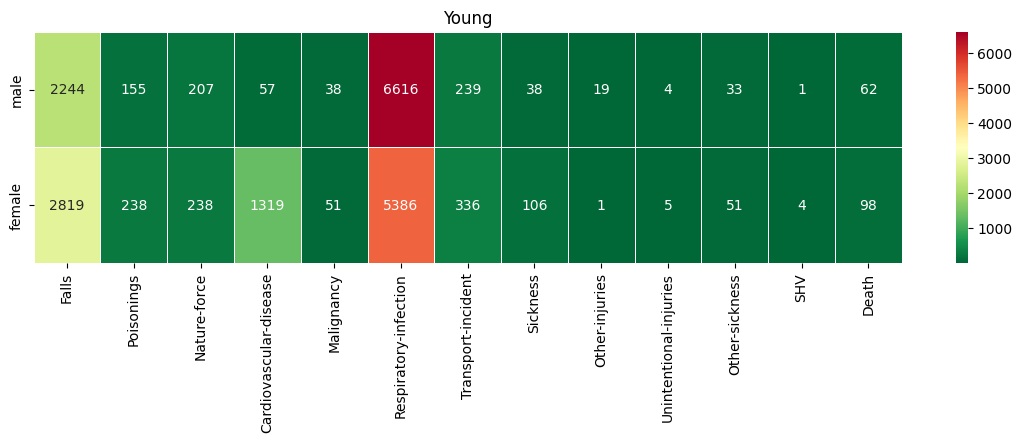

In [63]:
plt.figure(figsize=(14,3))
sns.heatmap(dataYoung, annot=True ,fmt="g", cmap='RdYlGn_r', linewidths=0.5).set_title("Young")
print()

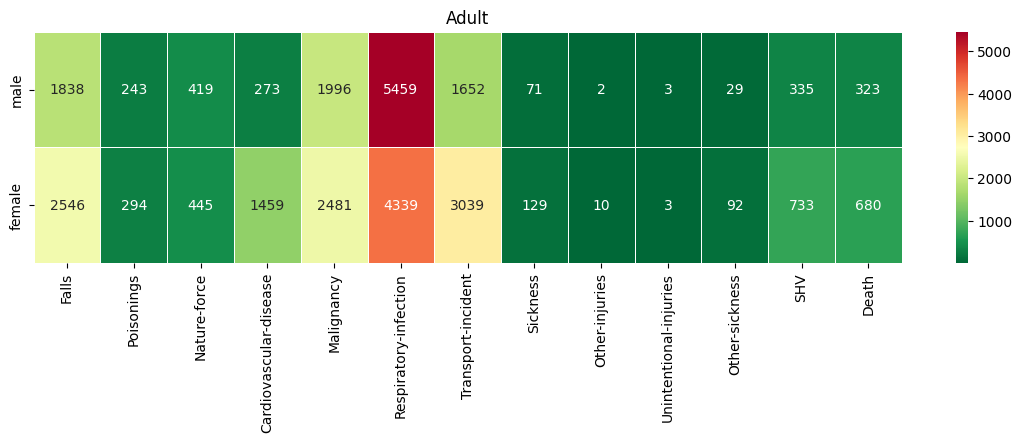

In [64]:
plt.figure(figsize=(14,3))
sns.heatmap(dataAdult, annot=True ,fmt="g", cmap='RdYlGn_r', linewidths=0.5).set_title("Adult")
print()

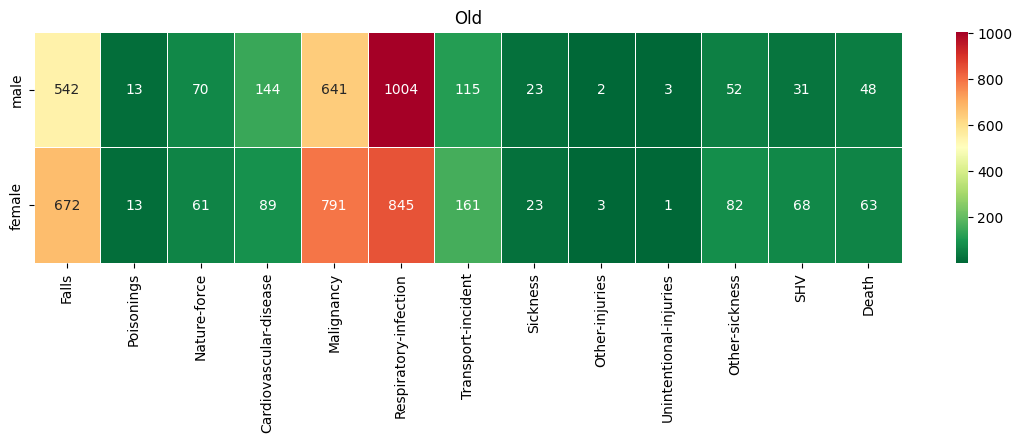

In [65]:
plt.figure(figsize=(14,3))
sns.heatmap(dataOld, annot=True ,fmt="g", cmap='RdYlGn_r', linewidths=0.5).set_title("Old")
print()

In [11]:
# estimator = HillClimbSearch(dataset.drop(np.arange(500,10000,9500)))

# hillclimb_model = estimator.estimate( scoring_method=BDsScore(dataset) )
# hillclimb_model = BayesianNetwork(hillclimb_model)
# draw_graph(hillclimb_model)

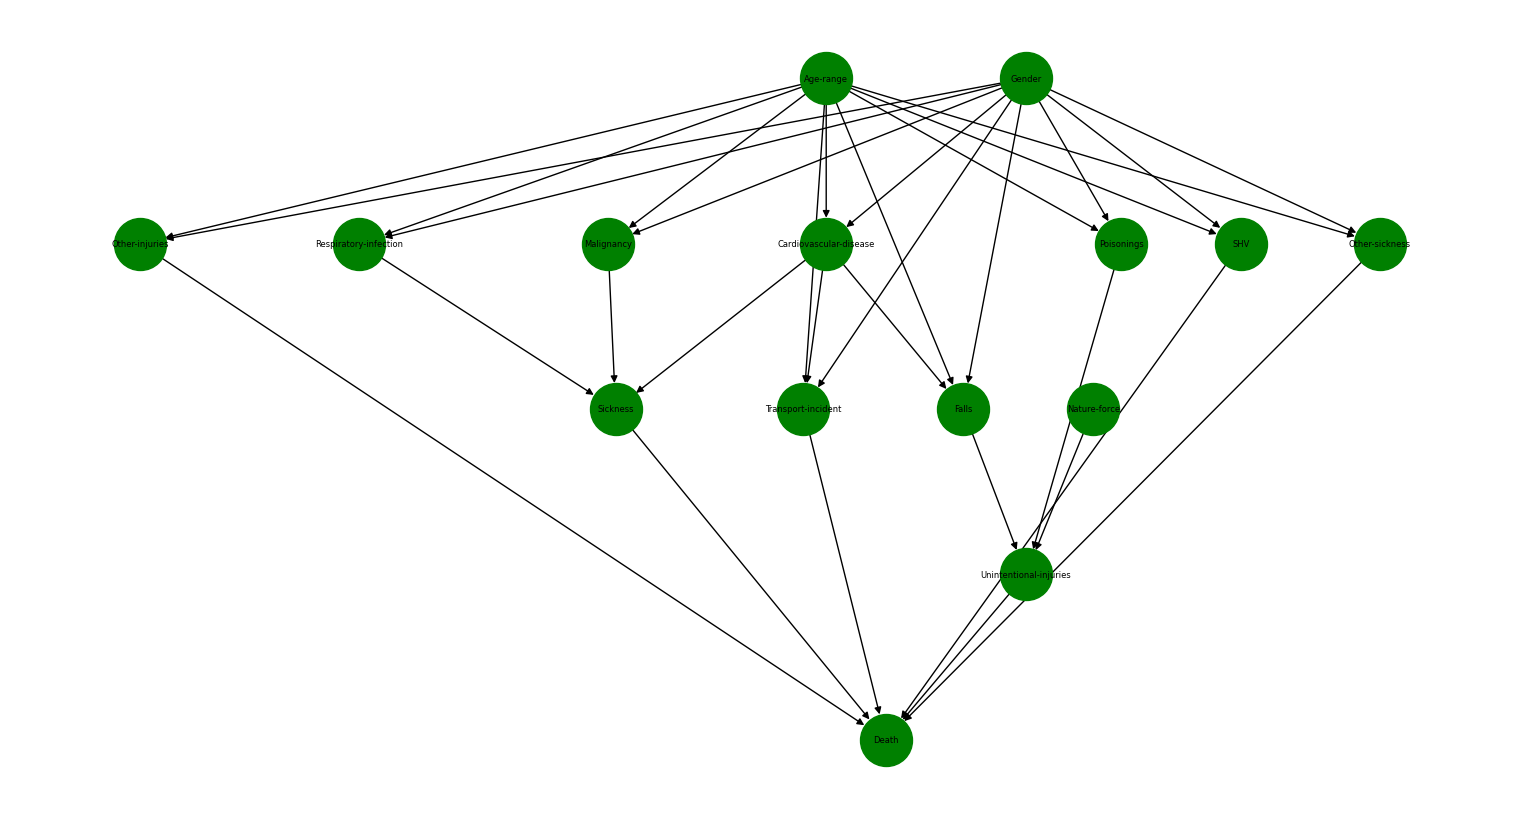

In [66]:
# Parameter estimation on manual model

manualConstructedModelFromDatabase = BayesianNetwork([
    ('Age-range', 'Other-injuries'), 
    ('Age-range', 'Falls'), 
    ('Age-range', 'Poisonings'), 
    ('Age-range', 'Transport-incident'), 
    ('Age-range', 'SHV'), 
    ('Age-range', 'Respiratory-infection'),
    ('Age-range', 'Malignancy'), 
    ('Age-range', 'Other-sickness'), 
    ('Age-range', 'Cardiovascular-disease'),
    ('Gender', 'Other-injuries'), 
    ('Gender', 'Falls'), 
    ('Gender', 'Poisonings'), 
    ('Gender', 'Transport-incident'), 
    ('Gender', 'SHV'), 
    ('Gender', 'Respiratory-infection'),
    ('Gender', 'Malignancy'), 
    ('Gender', 'Other-sickness'), 
    ('Gender', 'Cardiovascular-disease'),
    ('Cardiovascular-disease', 'Falls'), 
    ('Cardiovascular-disease','Transport-incident'),
    ('Cardiovascular-disease', 'Sickness'),
    ('Other-injuries', 'Death'),
    ('Unintentional-injuries','Death'),
    ('Falls', 'Unintentional-injuries'), 
    ('Poisonings', 'Unintentional-injuries'), 
    ('Nature-force', 'Unintentional-injuries'), 
    ('Transport-incident', 'Death'), 
    ('SHV', 'Death'), 
    ('Respiratory-infection', 'Sickness'), 
    ('Malignancy', 'Sickness'), 
    ('Other-sickness', 'Death'),
    ('Sickness', 'Death')
])

draw_graph(manualConstructedModelFromDatabase)


In [67]:
manualConstructedModelFromDatabase.cpds = []

d = data=dataset.drop("ID",axis=1)

manualConstructedModelFromDatabase.fit(data=d,
            estimator=BayesianEstimator,
            prior_type="BDeu",
            equivalent_sample_size=10,
            complete_samples_only=False,
)

print(f"Check model: {manualConstructedModelFromDatabase.check_model()=}")

for cpd in manualConstructedModelFromDatabase.get_cpds():
    print(f"CPT of {cpd.variable}")
    print(cpd)
    pass

Check model: manualConstructedModelFromDatabase.check_model()=True
CPT of Age-range
+------------------+-----------+
| Age-range(adult) | 0.599473  |
+------------------+-----------+
| Age-range(old)   | 0.0817452 |
+------------------+-----------+
| Age-range(young) | 0.318781  |
+------------------+-----------+
CPT of Other-injuries
+-------------------+-----+------------------------+
| Age-range         | ... | Age-range(young)       |
+-------------------+-----+------------------------+
| Gender            | ... | Gender(male)           |
+-------------------+-----+------------------------+
| Other-injuries(0) | ... | 0.9998859276158871     |
+-------------------+-----+------------------------+
| Other-injuries(1) | ... | 0.00011407238411282796 |
+-------------------+-----+------------------------+
CPT of Falls
+------------------------+-----+---------------------------+
| Age-range              | ... | Age-range(young)          |
+------------------------+-----+-------------------

In [79]:

def getPossibleGroups(evidences):
    values = []
    for evidence in evidences:
        values.append(evidence["values"])
    return list(itertools.product(*values))

# elements: array of tuples where the first element is the node of the query and the other elements are the evidences to use

def completeQueriesGenerator(model,elements):
    all_states = model.states
    all_queries = []
    for element in elements:
        node = element[0]
        queries = []
        evidences = []
        for i in range(1,len(element)):
            evidences.append({"evidence":element[i],"values":all_states[element[i]]})

        groups = getPossibleGroups(evidences)
        for group in groups: 
            evidences_obj = {}
            for evidence_value in zip(evidences, group): 
                curr_key = evidence_value[0]['evidence']
                evidences_obj[curr_key] = evidence_value[1]
            queries.append(([node], evidences_obj))        
        all_queries = all_queries + queries
    return all_queries

#q = completeQueriesGenerator(manualConstructedModelFromDatabase,(("Other-injuries","Age-range","Gender"),))

[(['Other-injuries'], {'Age-range': 'adult', 'Gender': 'female'}), (['Other-injuries'], {'Age-range': 'adult', 'Gender': 'male'}), (['Other-injuries'], {'Age-range': 'old', 'Gender': 'female'}), (['Other-injuries'], {'Age-range': 'old', 'Gender': 'male'}), (['Other-injuries'], {'Age-range': 'young', 'Gender': 'female'}), (['Other-injuries'], {'Age-range': 'young', 'Gender': 'male'})]


In [ ]:
# Inference
def inference(model, target, evidence):
    model_inference = VariableElimination(model)
    value = model_inference.query(target, evidence)
    return value

def plot_query_table(models, targets, evidence):
    model_to_phi = {}
    names = []
    for model in models:
        model_to_phi[model] = inference(model.model, targets, evidence)
        names.append(model.name)

    targets_values = {}
    for target in targets:
        targets_values[target] = variables_to_values[target]

    table_data = []
    combinations = list(itertools.product(*targets_values.values()))
    for combination in combinations:
        row_data = [*combination]

        for model in models:
            prob = round(model_to_phi[model].get_value(**dict(zip(targets_values.keys(), combination))), 4)
            row_data += [prob]

        table_data.append(row_data)

    fig, ax1 = plt.subplots(figsize=(len(combinations), len(targets) + len(models)))

    ccolors = np.full(len(targets) + len(models), "lavender")

    table = ax1.table(cellText=table_data,
                      cellLoc = "center",
                      colLabels= targets + names,
                      colColours = ccolors,
                      loc="center"
                      )

    table.scale(2,2)
    table.set_fontsize(12)
    ax1.axis("off")

    title = f"P({', '.join(targets)} | {', '.join([f'{k}={v}' for (k, v) in evidence.items()])})"

    ax1.set_title(title)


    #return tables

In [ ]:
def print_queries(model, queries):
    handWrittenQueries = [
        #(["X"], {"evidence": "value"}),   
    ]
    queries = queries + handWrittenQueries
    for query in queries:
        plot_query_table(model, *query)